# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

We used the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers.

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")

In [ ]:
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)

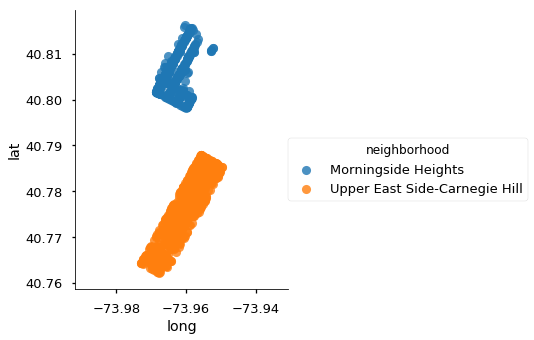

In [4]:
indicator_cols = ["pickup_latitude",
                  "pickup_longitude",
                  "dropoff_latitude",
                  "dropoff_longitude",
                  "manhattan_distance",
                  "pickup_hour",
                  "pickup_timestamp"]

y_cols = ["trip_duration"]

x_train, y_train, x_test, y_test = data.train_test_split(ues_to_msh,
                                                         0.2,
                                                         indicator_cols,
                                                         y_cols)
x_train_standardized = data.standardize_cols(x_train)
x_test_standardized = data.standardize_cols(x_test)

x_train_stan_poly = basis_functions.polynomial(x_train_standardized, degree = 3)
x_test_stan_poly = basis_functions.polynomial(x_test_standardized, degree = 3)

visualizations.visualize_by_borough(ues_to_msh)

# Model

In [5]:
def model(x_train, y_train):
    
    N, D = x_train.shape
    X = tf.placeholder(tf.float32, [N, D])
    w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
    b = ed.models.Normal(loc=[0.0], scale=1.0)
    alpha = ed.models.Normal(loc=[0.0], scale=1.0)
    Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=alpha)

    qalpha = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([1])),
                                                       tf.Variable(tf.zeros([1]))),
        bijector=tf.contrib.distributions.bijectors.Exp())

    qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                           scale=tf.Variable(tf.random_normal([D])))

    qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                           scale=tf.Variable(tf.random_normal([1])))

    inference = ed.KLqp({w: qw, b: qb, alpha: qalpha},
                        data={X: x_train.as_matrix(),
                              Y: np.reshape(y_train.as_matrix(), (y_train.shape[0]))})
    inference.run(n_iter=1000)
    
    return qw, qb, qalpha
qw, qb, qalpha = model(x_train_stan_poly, y_train)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 2182.073


# Critique

In [6]:
def critique(qw, qb, qalpha, x_test, y_test):
    N, D = x_test.shape
    X = tf.placeholder(tf.float32, [N, D])
    y_post = ed.models.Normal(loc=ed.dot(X, qw) + qb, scale=qalpha)
    print(ed.evaluate("mean_absolute_error",
                data={X: x_test.as_matrix(),
                      y_post: np.reshape(y_test.as_matrix(), (y_test.shape[0]))}))
critique(qw, qb, qalpha, x_test_stan_poly, y_test)

4.75938


In [ ]:
# TODO: eval with ppc

# T = lambda ws, bs, alphas: tf.maximum(ws[y_post])
# ed.ppc(T, data={})

# Visualize the model

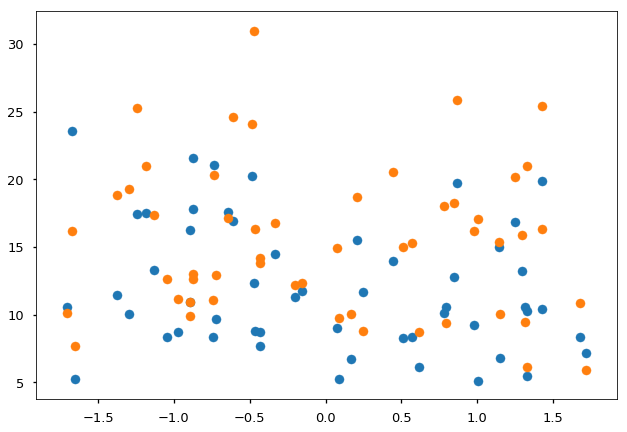

In [17]:
w = qw.sample(1).eval()
b = qb.sample(1).eval()
alpha = qalpha.sample(1).eval()
y_pred = np.dot(x_test.as_matrix(), w.T) + alpha
plt.scatter(x_test["pickup_timestamp"], y_pred)
plt.scatter(x_test["pickup_timestamp"], y_test_min)
plt.show()

### Results of a Linear Model
On average we have an absolute error of about 5:30 for each trip and the overall fit is not especially good.

# Gaussian Process

Lets try a different route. 

In [46]:
harlem_to_bat_park = data.get_neighborhood_to_neighborhood("East Harlem North", "Battery Park City-Lower Manhattan", manhattan)
bat_park_to_harlem = data.get_neighborhood_to_neighborhood("Battery Park City-Lower Manhattan", "East Harlem North", manhattan)
harlem_bat_park = pd.concat([harlem_to_bat_park, bat_park_to_harlem])

,Unnamed: 0,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_boro_code,dropoff_neighborhood_name,dropoff_neighborhood_code,pickup_timestamp,manhattan_distance,pickup_hour,dropoff_datetime,dropoff_hour,pickup_day_of_week,dropoff_day_of_week
0,18578.000000,id2767716,2.000000,2016-03-19 06:13:35,1.000000,-73.933273,40.803059,-74.007179,40.705158,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1458382415.000000,0.171806,6,2016-03-19 06:13:49.133333,6,5,5
1,223227.000000,id0540708,1.000000,2016-01-21 07:09:34,1.000000,-73.940240,40.793080,-74.011200,40.702000,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1453378174.000000,0.162040,7,2016-01-21 07:09:49.300000,7,3,3
2,255819.000000,id2602538,2.000000,2016-06-12 13:30:49,1.000000,-73.941020,40.792670,-74.001680,40.706990,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1465752649.000000,0.146340,13,2016-06-12 13:31:08.666667,13,6,6
3,264900.000000,id3761275,1.000000,2016-05-16 12:39:09,1.000000,-73.940230,40.797630,-74.012420,40.701660,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1463416749.000000,0.168160,12,2016-05-16 12:39:28.733333,12,0,0
4,492483.000000,id0347486,2.000000,2016-01-13 06:18:45,4.000000,-73.940740,40.792920,-74.007570,40.705020,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1452683925.000000,0.154730,6,2016-01-13 06:19:01.066667,6,2,2
5,1011247.000000,id3758638,2.000000,2016-05-03 21:27:52,1.000000,-73.931540,40.797790,-74.008670,40.704280,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1462325272.000000,0.170640,21,2016-05-03 21:28:06.533333,21,1,1
6,1190394.000000,id1949079,1.000000,2016-02-06 07:27:51,1.000000,-73.940240,40.793710,-74.011570,40.707830,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1454761671.000000,0.157210,7,2016-02-06 07:28:11.116667,7,5,5
7,1275879.000000,id2943060,1.000000,2016-02-11 06:23:06,1.000000,-73.933270,40.803370,-74.007180,40.705340,N,...,1.000000,Battery Park City-Lower Manhattan,MN25,1455189786.000000,0.171940,6,2016-02-11 06:23:23.800000,6,3,3
0,8082.000000,id0470895,1.000000,2016-01-11 21:53:05,1.000000,-74.007454,40.704784,-73.935799,40.812000,N,...,1.000000,East Harlem North,MN34,1452567185.000000,0.178871,21,2016-01-11 21:53:19.550000,21,0,0
1,29811.000000,id1311307,2.000000,2016-06-12 19:36:11,5.000000,-74.011780,40.702782,-73.944450,40.800541,N,...,1.000000,East Harlem North,MN34,1465774571.000000,0.165089,19,2016-06-12 19:36:32.450000,19,6,6


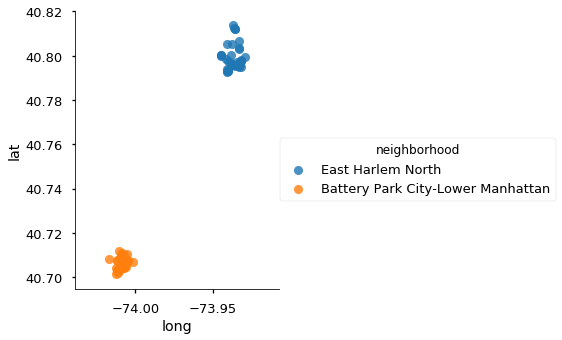

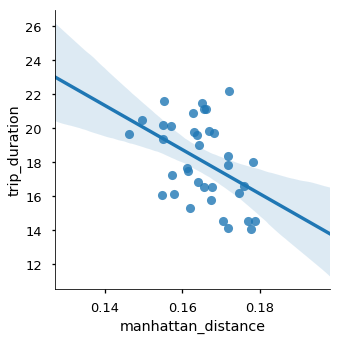

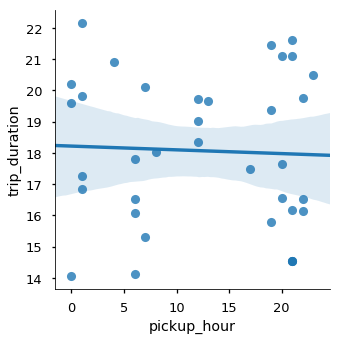

In [63]:
indicator_cols = ["pickup_latitude",
                  "pickup_longitude",
                  "dropoff_latitude",
                  "dropoff_longitude",
                  "manhattan_distance",
                  "pickup_hour",
                  "pickup_timestamp"]


y_cols = ["trip_duration"]

x_train, y_train, x_test, y_test = data.train_test_split(harlem_bat_park,
                                                         0.1,
                                                         indicator_cols,
                                                         y_cols)
x_train_standardized = data.standardize_cols(x_train)
x_test_standardized = data.standardize_cols(x_test)

visualizations.visualize_by_borough(harlem_bat_park)
sns.lmplot(x="manhattan_distance", y="trip_duration", data=harlem_bat_park)
sns.lmplot(x="pickup_hour", y="trip_duration", data=harlem_bat_park)
plt.show()

In [97]:
tf.reset_default_graph()
n_test, d_test = x_test_standardized.shape
y_n, y_d = y_train.shape
N, D = x_train_standardized.shape

x_test_node = tf.placeholder(tf.float32, [n_test, d_test])
x_node = tf.placeholder(tf.float32, [N, D])
y_node = tf.placeholder(tf.float32, [y_n, y_d])

mu, var = tf.nn.moments(y_node, 1)

v_i = tf.eye(N) * var

k = ed.rbf(x_node, lengthscale=0.9996, variance=1.0) + v_i
# k = ed.rbf(x_node, lengthscale=1.0) + v_i
k_star = ed.rbf(x_test_node, x_node)

k_star_star = ed.rbf(x_test_node)

k_inv = tf.matrix_inverse(k)

mu_star = tf.matmul(tf.matmul(k_star, k_inv), y_node)

tmp1 = tf.matmul(k_star, k_inv)

tmp2 = tf.matmul(tmp1, k_star, transpose_b=True)

v_star = k_star_star - tmp2

L = tf.cholesky(tf.abs(v_star))

p_y = ed.models.MultivariateNormalTriL(loc=mu_star, scale_tril=tf.abs(L))

expected = mu_star.eval(session=tf.Session(), feed_dict={
    x_node: x_train_standardized.as_matrix(),
    y_node: y_train.as_matrix(),
    x_test_node: x_test_standardized.as_matrix()
})

err = expected - y_test

print("actual", expected)
print("expected", y_test)
print("error", np.abs(err))
print("mean abs error", np.abs(err).mean())

actual [[ 15.21764565]
 [  5.60177088]
 [ 20.72358704]]
expected     trip_duration
22      14.050000
6       20.116667
1       21.450000
error     trip_duration
22       1.167646
6       14.514896
1        0.726413
mean abs error trip_duration   5.469651
dtype: float64
